In [1]:
using Revise
using DrWatson
@quickactivate "SpikingNeuralNetworks"
using SpikingNeuralNetworks
SNN.@load_units
import SpikingNeuralNetworks: AdExParameter, IFParameter, IFConstParameter, AdExConstParameter
using Statistics, Random
using Plots

# LKD model params

In [2]:
## Neuron parameters
τm = 20ms
C = 300pF # Capacitance
R = τm / C

## Neuron parameters
τre = 1ms # Rise time for excitatory synapses
τde = 6ms # Decay time for excitatory synapses
τri = 0.5ms # Rise time for inhibitory synapses 
τdi = 2ms # Decay time for inhibitory synapses

# Input and synapse paramater
N = 1000
νe = 4.5Hz # Rate of external input to E neurons 
νi = 2.25Hz # Rate of external input to I neurons 
p_in = 0.2 #1.0 # 0.5 
σ_in_E = 1.78pF

σEE = 2.76pF # Initial E to E synaptic weight
σIE = 48.7pF # Initial I to E synaptic weight
σEI = 1.27pF # Synaptic weight from E to I
σII = 16.2pF # Synaptic weight from I to I

Random.seed!(23)
duration = 700ms
pltdur = 70e1

700.0

## IF neuron with constant input current

In [3]:
LKD_IF_const = 
    IFConstParameter(τm = 20ms, Vt = -52mV, Vr = -60mV, El = -62mV, R = 20ms/300pF, τabs = 1ms)

IFNeuron = SNN.IFConst(; N = 1, param = LKD_IF_const)

SpikingNeuralNetworks.IFConst{Vector{Float32}, Vector{Bool}}(IFConstParameter{Float32}(20.0f0, -52.0f0, -60.0f0, -62.0f0, 66666.664f0, 1.0f0), 1, Float32[-55.061497], Bool[0], Float32[0.0], Dict{Any, Any}(), [0.0])

In [4]:
#
P = [IFNeuron]
C = []

SNN.monitor([IFNeuron], [:v, :fire]) 
SNN.sim!(P, C; duration = duration)

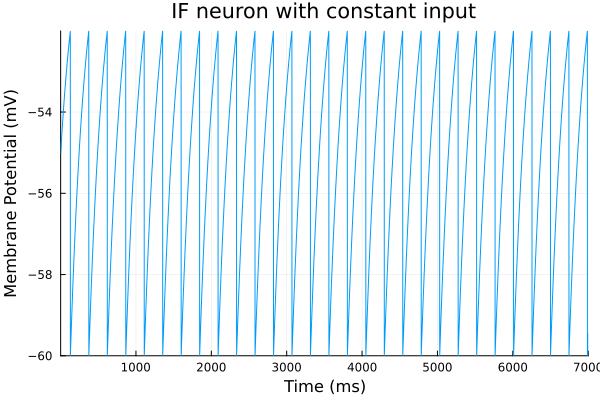

In [5]:
p1 = plot(SNN.vecplot(IFNeuron, :v),
xlabel = "Time (ms)", 
ylabel = "Membrane Potential (mV)", 
title = "IF neuron with constant input")

## AdEx neuron with constant input current

In [6]:
LKD_AdEx_const = 
    AdExConstParameter(τm = 20ms, Vt = -52mV, Vr = -60mV, El = -70mV, R = 20ms/300pF, ΔT = 2mV, a = 4nS, b = 0.805pA, 
    τw = 150ms, τabs = 1ms, At = 10mV, τT = 30ms)

AdExNeuron = SNN.AdExConst(; N = 1, param = LKD_AdEx_const)

SpikingNeuralNetworks.AdExConst{Vector{Float32}, Vector{Bool}}(AdExConstParameter{Float32}(20.0f0, -52.0f0, -60.0f0, -70.0f0, 66666.664f0, 0.0003f0, 2.0f0, 4.0f-6, 8.05f-7, 150.0f0, 1.0f0, 10.0f0, 30.0f0), 1, Float32[-54.385963], Float32[0.0], Bool[0], Float32[-52.0], Float32[0.0], Dict{Any, Any}(), [0.0])

In [7]:
P = [AdExNeuron]
C = []

SNN.monitor([AdExNeuron], [:v, :fire, :w]) 
SNN.sim!(P, C; duration = duration)

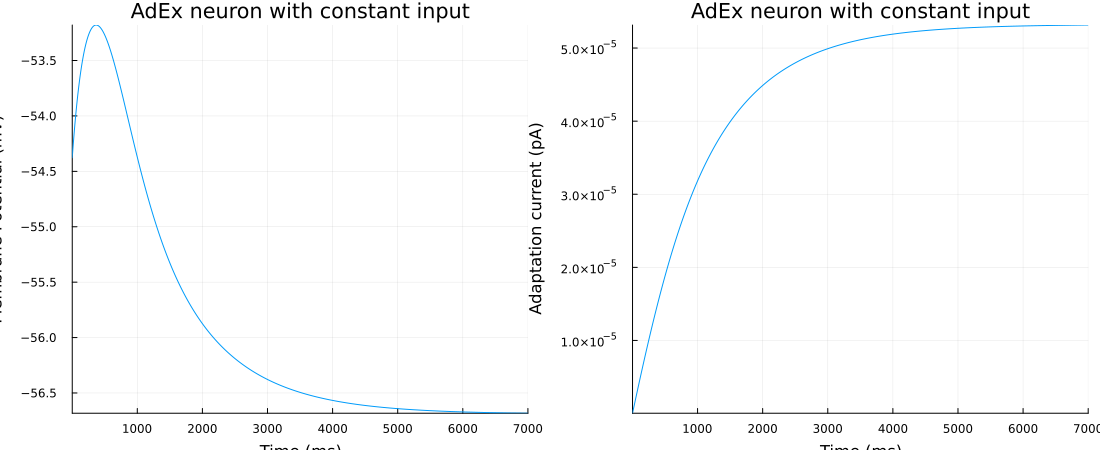

In [8]:
p1 = plot(SNN.vecplot(AdExNeuron, :v),
xlabel = "Time (ms)", 
ylabel = "Membrane Potential (mV)")
p2 = plot(SNN.vecplot(AdExNeuron,:w),
xlabel = "Time (ms)",
ylabel = "Adaptation current (pA)")
plot(p1,p2, size=(1100,450), title = "AdEx neuron with constant input")

## Adex neuron with Poisson input

In [9]:
LKD_AdEx_exc = 
    AdExParameter(τm = 20ms, Vt = -52mV, Vr = -60mV, El = -70mV, R = 20ms/300pF, ΔT = 2mV, τw = 150ms, a = 4nS,
    b = 0.805pA, τabs = 1ms, τre = τre, τde = τde, τri = τri, τdi = τdi, E_i = -75mV, E_e = 0mV, At = 10mV, τT = 30ms)

E = SNN.AdEx(; N = 1, param = LKD_AdEx_exc)

Input_E = SNN.Poisson(; N = 500, param = SNN.PoissonParameter(; rate = νe))
ProjE = SNN.SpikingSynapse(Input_E, E, :ge; σ = σ_in_E, p = p_in) # connection from input to E

SpikingNeuralNetworks.no_STDP{Vector{Int32}, Vector{Float32}, Vector{Bool}}(SpikingNeuralNetworks.no_STDPParameter(), Int32[1, 113], Int32[1, 1, 1, 1, 2, 3, 3, 3, 4, 5  …  109, 109, 110, 111, 111, 112, 112, 112, 113, 113], Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Int32[4, 5, 8, 9, 15, 18, 33, 43, 46, 52  …  468, 469, 470, 484, 488, 489, 493, 494, 496, 499], Int32[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  103, 104, 105, 106, 107, 108, 109, 110, 111, 112], Float32[1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6  …  1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6], Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Float32[0.0], Dict{Any, Any}())

In [10]:
P = [E, Input_E]
C = [ProjE]

SNN.monitor([E], [:v, :fire, :w]) 
SNN.sim!(P, C; duration = duration)

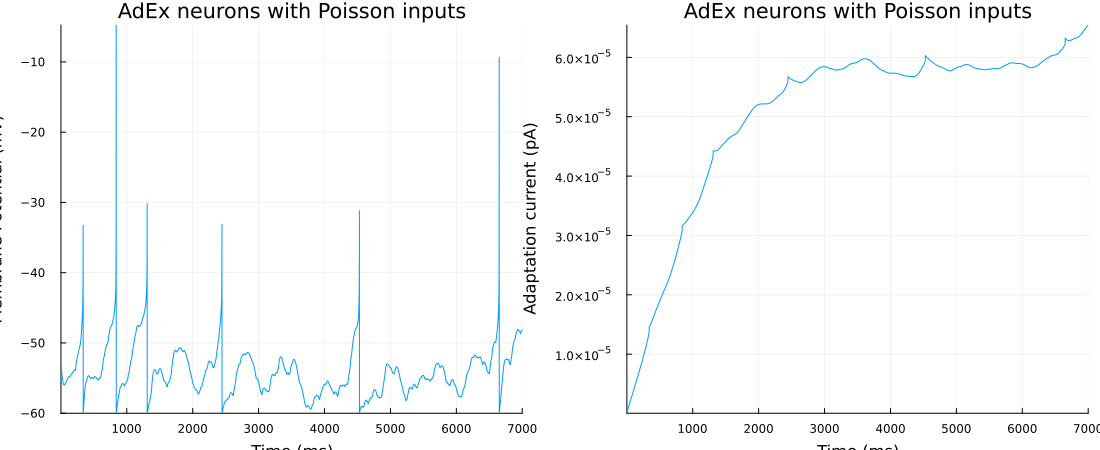

In [11]:
p1 = plot(SNN.vecplot(E,:v),
xlabel = "Time (ms)", 
ylabel = "Membrane Potential (mV)")
p2 = plot(SNN.vecplot(E,:w),
xlabel = "Time (ms)",
ylabel = "Adaptation current (pA)")
plot(p1,p2, size=(1100,450), title = "AdEx neurons with Poisson inputs")

## IF neuron with Poisson input

In [12]:
LKD_IF_inh =
    IFParameter(τm = 20ms, Vt = -52mV, Vr = -60mV, El = -62mV, R = 20ms/300pF, ΔT = 2mV, 
    τre = τre, τde = τde, τri = τri, τdi = τdi, E_i = -75mV, E_e = 0mV, τabs = 1ms)

I = SNN.IF(; N = 1, param = LKD_IF_inh)

Input_I = SNN.Poisson(; N = 500, param = SNN.PoissonParameter(; rate = νi))
ProjI = SNN.SpikingSynapse(Input_I, I, :ge; σ = σ_in_E, p = p_in)

SpikingNeuralNetworks.no_STDP{Vector{Int32}, Vector{Float32}, Vector{Bool}}(SpikingNeuralNetworks.no_STDPParameter(), Int32[1, 97], Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 2  …  97, 97, 97, 97, 97, 97, 97, 97, 97, 97], Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Int32[9, 10, 13, 39, 41, 47, 49, 53, 59, 60  …  464, 468, 470, 475, 479, 484, 485, 486, 490, 491], Int32[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  87, 88, 89, 90, 91, 92, 93, 94, 95, 96], Float32[1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6  …  1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6, 1.78f-6], Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Float32[0.0], Dict{Any, Any}())

In [13]:
P = [I, Input_I]
C = [ProjI]

SNN.monitor([I], [:v, :fire]) 
SNN.sim!(P, C; duration = duration)

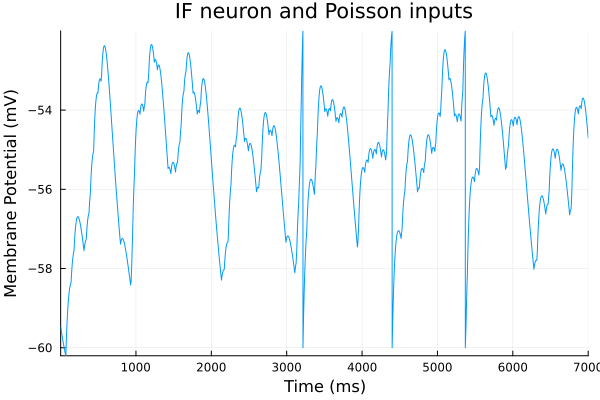

In [14]:
p1 = plot(SNN.vecplot(I,:v),
xlabel = "Time (ms)", 
ylabel = "Membrane Potential (mV)", 
title = "IF neuron and Poisson inputs")

## AdEx excitatory and IF inhibitory

In [15]:
E = SNN.AdEx(; N = 1, param = LKD_AdEx_exc)
I = SNN.IF(; N = 1, param = LKD_IF_inh)

Input_E = SNN.Poisson(; N = 600, param = SNN.PoissonParameter(; rate = νe))
ProjE = SNN.SpikingSynapse(Input_E, E, :ge; σ = σ_in_E, p = p_in) # connection from input to E
Input_I = SNN.Poisson(; N = 150, param = SNN.PoissonParameter(; rate = νi))
ProjI = SNN.SpikingSynapse(Input_I, I, :ge; σ = σ_in_E, p = p_in)

EI = SNN.SpikingSynapse(E, I, :ge; σ = σEI, p = 1.0)
IE = SNN.SpikingSynapse(I, E, :gi; σ = σIE, p = 1.0, param=SNN.iSTDPParameter())
EE = SNN.SpikingSynapse(E, E, :ge; σ = σEE, p = 1.0, param=SNN.vSTDPParameter())
II = SNN.SpikingSynapse(I, I, :gi; σ = σII, p = 1.0)

SpikingNeuralNetworks.no_STDP{Vector{Int32}, Vector{Float32}, Vector{Bool}}(SpikingNeuralNetworks.no_STDPParameter(), Int32[1, 2], Int32[1, 2], Int32[1], Int32[1], Int32[1], Float32[1.62f-5], Bool[0], Float32[0.0], Dict{Any, Any}())

In [16]:
P = [E, I, Input_E, Input_I]
C = [EE, II, EI, IE, ProjE, ProjI]

SNN.monitor([E, I], [:v, :fire]) 
SNN.train!(P, C; duration = duration)

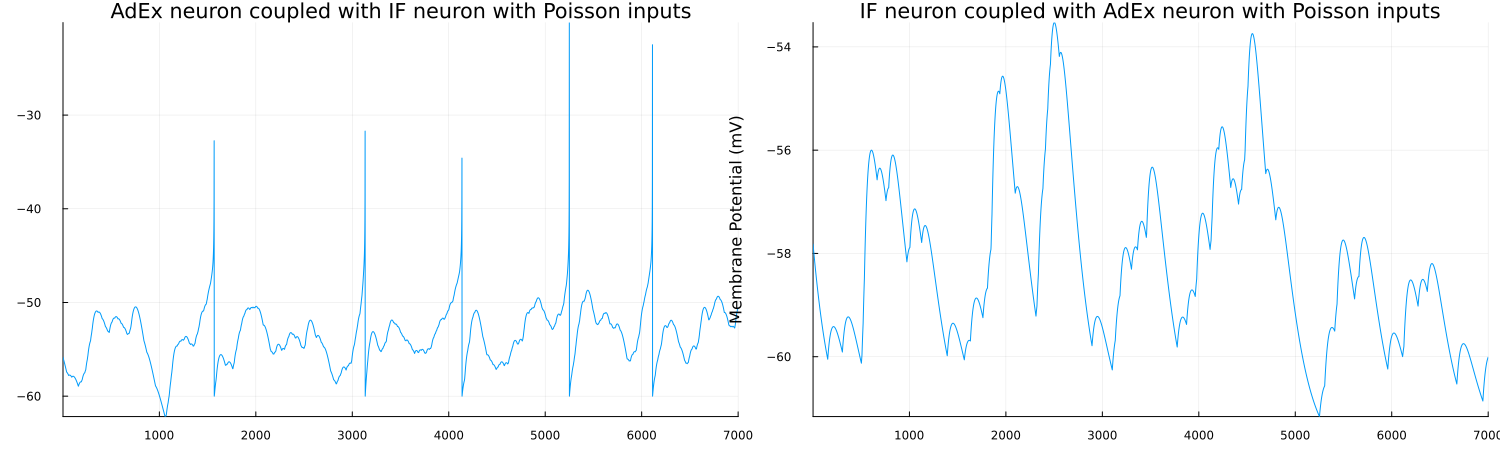

In [17]:
p1 = plot(SNN.vecplot([E], :v),
xlabel = "Time (ms)", 
ylabel = "Membrane Potential (mV)", 
title = "AdEx neuron coupled with IF neuron with Poisson inputs")
p2 = plot(SNN.vecplot([I], :v),
xlabel = "Time (ms)",
ylabel = "Membrane Potential (mV)", 
title = "IF neuron coupled with AdEx neuron with Poisson inputs")
plot(p1, p2, size=(1500, 450))